# Filtering vcf files
This is a script based on [this](https://github.com/avignal5/SeqApiPop/blob/master/Scripts_2_VcfCleanup/diagnostic.r). Its purpose is to allow for easy plotting of the various statistics present in a vcf file. These are then to be used to explore the effects of the different filters and filter thresholds on the data. 

The original version, written in R by the SeqApiPop authors is more complete, it allows for integration with bash scripts and also guesses which type of plot to draw from the input. It also decides when to draw a logarithmic plot. 

This python version does not do any of that, it just plots the data as specified by the user. It is up to the user to decide whether to use logarithmic scaling or not. 

All in all, the orignal R versions by SeqApiPop should be used at all times. This is merely an exercise in pyhton.

## Preparing the data for plotting
The data needs to be prepared using a couple of short bash scripts. There are three scripts that needs to be run, which one depends on the type of the parameter we wish to plot. 

The three groups:
1. het or miss
2. gq
3. everything else

# Preparing data for het/miss

```
% bash
#! bin/bash
# Get the stats needed to plot het, miss, and gq
# The code I am imitating is found here:
# https://github.com/avignal5/SeqApiPop/blob/master/Scripts_2_VcfCleanup/vcf_cleanup.sh

# Get genotypes
vcfin=$1  # Name of the file we want to process, along with the path to it
dirout=$2  # The second path specified will be the name of the directory we want the output ot be written in

vcfin_bname=$(basename "$vcfin")
vcfin_bname=${vcfin_bname%.vcf*}  # removes the extension
bcftools query -f '%CHROM %POS [ %GT]\n' $vcfin > ${dirout}${vcfin_bname}_geno.txt
split -l 100000 ${dirout}/${vcfin_bname}_geno.txt ${dirout}/geno_${vcfin_bname}_

for file in ${dirout}/geno_*
  do
    mv "${file}" "${file}".gt
  done
  ```
  

## Prepare data for gq

```
#! bin/bash
vcfin=$1  # Name of the file we want to process, along with the path to it
dirout=$2  # The second path specified will be the name of the directory we want the output ot be written in
vcfin_bname=$(basename "$vcfin")
vcfin_bname=${vcfin_bname%.vcf*}  # removes the extension
bcftools query -f '%CHROM %POS [ %GQ]\n' $vcfin > ${dirout}${vcfin_bname}_gq.txt
split -l 100000 ${dirout}/${vcfin_bname}_gq.txt ${dirout}/gq_${vcfin_bname}_

for file in ${dirout}/gq_*
  do
    mv "${file}" "${file}".gq
  done
```


### Preparing data for everything else
```
# Making the info table from a vcf file
# this is a script for getting a table from a vcf file, the table will then be parsed using python
# the commmands were taken from https://github.com/avignal5/SeqApiPop/blob/master/Scripts_2_VcfCleanup/vcf_cleanup.sh

bcftools query -f '%CHROM %POS %REF %ALT %FS %SOR %MQ %MQRankSum %ReadPosRankSum %QUAL %QD\n' "FILENAME.vcf.gz" > tables/info.txt
head='CHROM POS REF ALT FS SOR MQ MQRankSum ReadPosRankSum QUAL QD\n'
sed -i "1s/^/${head}/" "tables/info.txt"
``` 

## Parsing the data

### Parsing the data for GQ and GQ proportion

In [1]:
# Importing stuff
import numpy as np
from numpy import genfromtxt
import pandas as pd
import math
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import glob
import collections

In [2]:
# Count the occurance of gq values in the files which were split from the original vcf file
def get_gq(path):
    gt_file_list = [file for file in glob.glob(f"{path}*.gq")]

    # Get the total sum of each GQ value (0 to 99 possible)
    gq_counts_list = []  # a list of the ocunts for each file
    for file in gt_file_list:
        # select the genotype using indexing
        gq = pd.read_csv(file, delimiter=" ", header=None, na_values=".")  # dleimiter appears to be a space, "." = Na
        gq.rename(columns={0: "chrom", 1: "pos"}, inplace=True)

        # Select only the values and not the chrom and pos columns
        gq.drop(["chrom", "pos"], axis=1, inplace=True)

        # Count the occurances of unique values in the dataframe
        gq_counts_list.append(gq.stack().value_counts())

    # Concat all counts
    gq_counts = pd.concat(gq_counts_list, axis=1)  # concat along columns axis

    # Count the occurances of values
    gq_sums = gq_counts.sum(axis=1)
    gq_sums = gq_sums.to_numpy()
    return gq_sums


# Show the counts of SNPs with proporiton of samples with GQ less than filter value/threshold
#TODO: Must check if the way proportion is calculated is correct, do we divide by all samples number or by only the
# number of samples which have the genotype called? For now it remains as in the example
def get_gq_proportion(path, filter_value):
    gt_file_list = [file for file in glob.glob(f"{path}*.gq")]

    sum_df = pd.DataFrame()
    for file in gt_file_list:
        # select the genotype using indexing
        gq = pd.read_csv(file, delimiter=" ", header=None, na_values=".")  # dleimiter appears to be a space
        gq.rename(columns={0: "chrom", 1: "pos"}, inplace=True)

        # calculate the share of missing/hetero calls at each position
        count_all = len(gq.columns) - 2  # minus two since the first two columns are chrom and pos; we want sample cols only
        below_filter_value = gq[gq.columns.difference(["chrom", "pos"])] < filter_value          # count the number of values below filter value
        count_below_filter_value = below_filter_value.sum(axis=1)
        share_below_filter_value = count_below_filter_value/count_all

        # Make the data frame with the new values
        gq_tmp = gq[["chrom", "pos"]].copy()  # the data frame we will use to append the temporary results in
        gq_tmp[filter_name] = share_below_filter_value  # add the new column

        # Concat the temp df to the sum_df where all sub-files will be concatenated -- this is the mem saving part
        sum_df = sum_df.append(gq_tmp)
    data = sum_df[filter_name].dropna().to_numpy(dtype=float)
    return sum_df, data  # data is what we need to plot the graph, sum_df is the entire df


### Parsing the data for het/miss
The function needs two arguments, the path to the dir where the output files from the bash script "get_genotypes.sh" are, and the name of the filter we wish to plot. 

In [22]:
# Get the data into a format suotable for plotting
def get_het_or_miss(path, filter_name):
    gt_file_list = [file for file in glob.glob(f"{path}*.gt")]
    het = ['0/1', '0|1', '0/2', '0|2', '0/3', '0|3', '1/2', '1|2', '1/3', '1|3', '2/3', '2|3']
    miss = ['./.', '.|.', '.']
    filter_names = {"HET": het,
                    "het": het,
                    "Het": het,
                    "MISS": miss,
                    "miss": miss,
                    "Miss": miss}

    sum_df = pd.DataFrame()
    for file in gt_file_list:
        # select the genotype using indexing
        gt = pd.read_csv(file, delimiter=" ", header=None, na_values=".") # dleimiter appears to be a space
        gt.rename(columns={0: "CHROM", 1: "POS"}, inplace=True)

        # calculate the share of missing/hetero calls at each position
        sum_all = len(gt.columns) - 2  # minus two since the first two columns are chrom and pos; we want sample cols only
        sum_invalid = gt.isin(filter_names[filter_name]).sum(axis=1)  # sum the genotypes of interest in each row
        share_invalid = sum_invalid/sum_all  # series with calculated share of gt of interest out of all samples per locat.

        # Make the data frame with the new values
        gt_tmp = gt[["CHROM", "POS"]].copy()  # the data frame we will use to append the temporary results in
        gt_tmp[filter_name] = share_invalid  # add the new column

        # Concat the temp df to the sum_df where all sub-files will be concatenated -- this is the mem saving part
        sum_df = sum_df.append(gt_tmp)
    data = sum_df[filter_name].dropna().to_numpy(dtype=float)
    return data  # sum_df is the entire df, data is what we need to plot the graph

### Parsing the info table for everything else
It should be noted that some rows in the "info_table.txt" usually contain "." characters. These need to be changed to NaN or something like that, else parsing using pandas breaks. This is taken care of by the `na_values="."` option in pandas. As far as I know these appear in the vcf file as missing value indicators.

Reading a large file requires (I think) the data type to be set, else pandas tries to guess the data type -- but only after reading the whole column into memory. This apparently takes time. If the data type does not match the one specified it throws an error.

In [4]:
# Parsing the info_table (generated using bcftools and a sed command to add the header)
def parse_info_table(info_table):
    data_type = {"CHROM": str,
                 "POS": int,
                 "REF": str,
                 "ALT": str,
                 "FS": float,
                 "SOR": float,
                 "MQ": float,
                 "MQRankSum": float,
                 "ReadPosRankSum": float,
                 "QUAL": float,
                 "QD": float}

    # Read the data frame, missing values are marked with a "." in the original file
    data = pd.read_csv(info_table,
                       na_values=".",  # get rid of . in the info table, could be problematic
                       dtype=data_type,
                       delimiter=" ",
                       header=0)
    return(data)  # return the dataframe of the info table

## Plotting functions
These are again almost completely translated from the original R code. The filter name argument of the functions matches a name of a column in the info table. It is then also used in the labels of the x and y axis, as well as the title.

In [5]:

def plot_histogram(data, filter_name, filter_value, quant):
    if filter_name == "GQ":
        fig, ax = plt.subplots()  # create a new figure containing as single axes
        plt.bar(np.arange(0, 100), data, fc=(0, 0, 0, 0), edgecolor="k", align="center")
    else:
        num_bins = 200  # copied from the R script
        fig, ax = plt.subplots()  # create a new figure containing as single axes

        # Plot the histogram
        n, bins, patches = plt.hist(data, num_bins, fc=(0, 0, 0, 0), edgecolor="k")
    # Check if quant parameter is set, if yes, prepare for iteration if multiple values are passed
    if quant:  # if not iterable, make it iterable for below code to work
        if isinstance(filter_value, collections.Iterable):
            pass  # it is iterable, so let it be
        else:
            filter_value = (filter_value,)  # create a single element tuple for iteration

        # if filter_name not in ("GQ", "GQ_proportion"):
        # Calculate percentile in quesiton, filter_value must be float
        if filter_name != "GQ":
            quantiles = []
            for i in filter_value:  # Calc and plot all the quantiles in the quantiles in the filter_value parameter
                quantile = np.quantile(data, i)
                quantiles.append(quantile)
                plt.axvline(x=quantile, color="r", linestyle="--")
                trans = ax.get_xaxis_transform()
                ax.text(quantile - 0.1, 0.8,
                        f"{i * 100}-th percentile",
                        rotation=90,
                        transform=trans,
                        color="r")
        else:
            quantiles = []
            # Calculate cumsum for the data
            c_sum = np.cumsum(data)
            for i in filter_value:  # filter values are quantile probs in this case
                sum_below_quantile = i * c_sum[-1]
                idx = (np.abs(c_sum - sum_below_quantile)).argmin()
                quantile = idx
                quantiles.append(quantile)
                plt.axvline(x=quantile, color="r", linestyle="--")
                trans = ax.get_xaxis_transform()
                ax.text(quantile - 1, 0.8,
                        f"{i * 100}-th percentile",
                        rotation=90,
                        transform=trans,
                        color="r")
    else:
        plt.axvline(x=filter_value, color="r", linestyle="--")
        ax.text(filter_value - 0.2, 0.8,
                f"{filet_value}",
                rotation=90,
                transform=trans,
                color="r")
    # Add the vertical filter indicator line, fix aesthetics, titles etc.
    ax.set_xlabel(filter_name)
    ax.set_ylabel("Frequency of markers")
    ax.set_title(f"Histogram of {filter_name}", fontsize=14)

    if filter_name == "GQ":
        plt.locator_params(axis="x", nbins=20)
        ax.minorticks_on()

    # Remove the top and right spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

                               
# Log histogram plotting function
def plot_log_histogram(filter_name, filter_value, data, quant):
    num_bins = 200  # originally 200, but I want to have the extra bin number 1 reserved for 0.0
    fig, ax = plt.subplots()  # create a new figure containing as single axes

    # Fix log scale if there is a zero value in the dataset since log 0 does not exist
    if min(data) == 0.0:
        num_bins = 199  # reduce the number of bins by 1, since we will be addign a custom bin -- 0 bin later
        data = np.sort(data)
        data_no_zero = np.delete(data, np.where(data == 0.0))  # remove the offending 0, which does not play nice with log
        logbins = np.geomspace(data_no_zero.min(), data_no_zero.max(), num_bins)  # get the log bins, no zero here
        logbins = np.concatenate(([0.0], logbins))
    # Else there is no 0 value in the data, we do not need to add the 0 bin
    else:
        logbins = np.geomspace(data.min(), data.max(), num_bins)


    # Plot the histogram
    n, bins, patches = plt.hist(data, bins=logbins, fc=(0, 0, 0, 0), edgecolor="k")
    plt.xscale("log")

    # Check if quant parameter is set, if yes, prepare for iteration if multiple values are passed
    if quant:  # if not iterable, make it iterable for below code to work
        if isinstance(filter_value, collections.Iterable):
            pass  # it is iterable, so let it be
        else:
            filter_value = (filter_value,)  # create a single element tuple for iteration

        # Calculate percentile in quesiton, filter_value must be float
        quantiles = []
        for i in filter_value:  # Calc and plot all the quantiles in the quantiles in the filter_value parameter
            quantile = np.quantile(data, i)
            quantiles.append(quantile)
            plt.axvline(x=quantile, color="r", linestyle="--")
            trans = ax.get_xaxis_transform()
            ax.text(quantile - 0.1, 0.8,
                    f"{i * 100}-th percentile",
                    rotation=90,
                    transform=trans,
                    color="r")
    else:
        plt.axvline(x=filter_value, color="r", linestyle="--")

    # Fix aesthetics
    ax.set_xlabel(f"log_{filter_name}")
    ax.set_ylabel("Frequency of markers")
    ax.set_title(f"Histogram of log_{filter_name}", fontsize=14)

    # Remove the top and right spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    # Return percentile for a given filter_value or vice versa
    if quant:
        return quantiles

# ECDF (empirical distribution function) plotting function
def plot_ecdf(filter_name, filter_value, data, quant):
    # find the unique values nad their corresponding counts
    quantiles, counts = np.unique(data, return_counts=True)

    # take the cumulative sum of the counts and divide by the sample size to
    # get the cumulative probabilities between 0 and 1
    cumprob = np.cumsum(counts).astype(np.double) / data.size

    # do the plotting
    fig, ax = plt.subplots()
    ax.plot(quantiles, cumprob, color="k")

    if quant:
        plt.axhline(y=filter_value, color="r", linestyle="--")
        # Get the x axis value at y == filter value (aka. quantile)
        idx_y = (np.abs(cumprob - filter_value)).argmin()
        x_value = quantiles[idx_y]
        plt.axvline(x=x_value, color="r", linestyle="--")
    else:
        # Plot the vertical line (filter value) and the corresponding y value
        plt.axvline(x=filter_value, color="r", linestyle="--")
        # Get the intercept on y value at x == filter_value
        idx = (np.abs(quantiles - filter_value)).argmin()   # returns of the closest value to the filter value
        y_value = cumprob[idx]  # the indices of the quantiels array and the cumprob array match, so we can use one to index the other
        plt.axhline(y=y_value, color="r", linestyle="--")

    # Add text to lines
    trans_y = ax.get_yaxis_transform()
    trans_x = ax.get_xaxis_transform()
    ax.text(0.8, filter_value,
            f"{filter_value * 100}-th percentile",
            transform=trans_y,
            color="r")
    ax.text(x_value - 0.1, 0.8,
            f"{x_value}",
            transform=trans_x,
            color="r",
            rotation=90)
    # Fix aesthetics
    ax.set_xlabel(filter_name)
    ax.set_ylabel("Proportion of markers")
    ax.set_title(f"ECDF of {filter_name}", fontsize=14)

    # Remove the top and right spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)



# ECDF log plotting function
def plot_log_ecdf(filter_name, filter_value, data, quant):
    # find the unique values nad their corresponding counts
    quantiles, counts = np.unique(data, return_counts=True)

    # take the cumulative sum of the counts and divide by the sample size to
    # get the cumulative probabilities between 0 and 1
    cumprob = np.cumsum(counts).astype(np.double) / data.size

    # do the plotting
    fig, ax = plt.subplots()
    ax.plot(quantiles, cumprob, color="k")
    ax.set_xscale("log")

    if quant:
        if filter_value > 1:
            raise ValueError("When quant == True filter value (quantiles) must be in range [0:1]")
        plt.axhline(y=filter_value, color="r", linestyle="--")
        # Get the x axis value at y == filter value (aka. quantile)
        idx_y = (np.abs(cumprob - filter_value)).argmin()
        x_value = quantiles[idx_y]
        plt.axvline(x=x_value, color="r", linestyle="--")
    else:
        # Plot the vertical line (filter value) and the corresponding y value
        plt.axvline(x=filter_value, color="r", linestyle="--")
        # Get the intercept on y value at x == filter_value
        idx = (np.abs(quantiles - filter_value)).argmin()   # returns of the closest value to the filter value
        y_value = cumprob[idx]  # the indices of the quantiels array and the cumprob array match, so we can use one to index the other
        plt.axhline(y=y_value, color="r", linestyle="--")

    # Add text to lines
    trans_y = ax.get_yaxis_transform()
    trans_x = ax.get_xaxis_transform()
    ax.text(0.8, filter_value,
            f"{filter_value * 100}-th percentile",
            transform=trans_y,
            color="r")
    ax.text(x_value - 0.1, 0.8,
            f"{x_value}",
            transform=trans_x,
            color="r",
            rotation=90)

    # Fix aesthetics
    ax.set_xlabel(f"log_{filter_name}")
    ax.set_ylabel("Proportion of markers")
    ax.set_title(f"ECDF of log {filter_name}", fontsize=14)

    # Remove the top and right spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)


## Plotting a test example (Harpur's HarpurPNAS.vcf.gz).
### Strand Odds Ratio (SOR) -- historgram, ECDF

In [6]:
# Magic function for using the inline bakcend -- not sure when to use this, maybe it saves
# the images along with the code in the jupyter notebook.
%matplotlib inline
plt.style.use("default")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (7, 7)

In [7]:
# Parse the info_table
paths = ["./tables/drones_2020/", 
         "./tables/drones_2020_removed_het_collapse_all/",
         "./tables/drones_2020_removed_het_collapse_none/"
        ]
info_tables = []
for i in paths:
    info_table = parse_info_table(f"{i}info.txt")
    info_tables.append(info_table)

### Strand odds-ratio

/tmp/ipykernel_51737/2489839832.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if isinstance(filter_value, collections.Iterable):


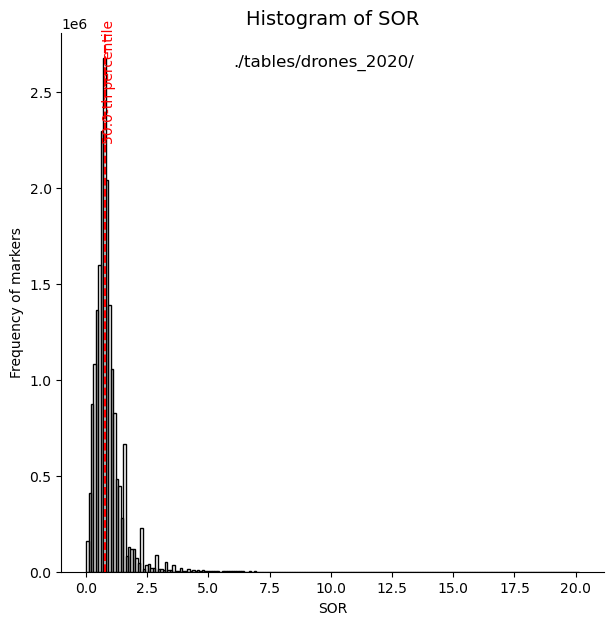

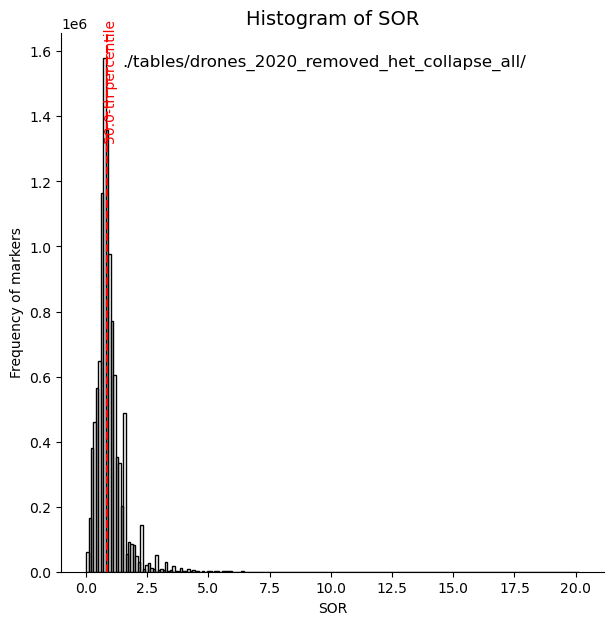

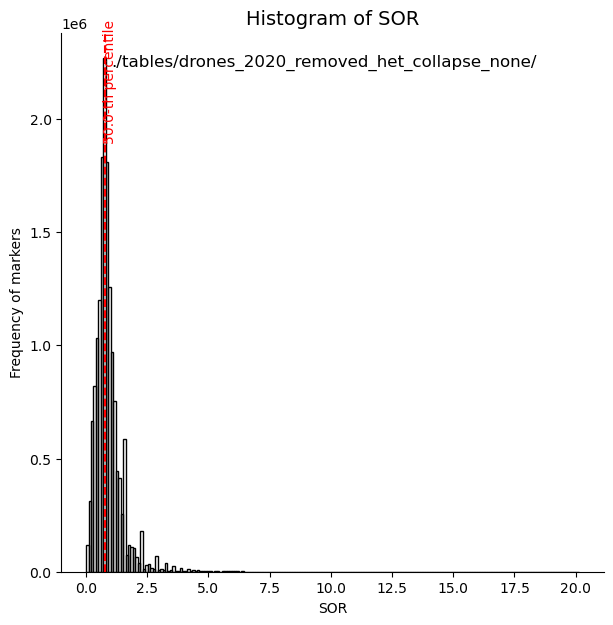

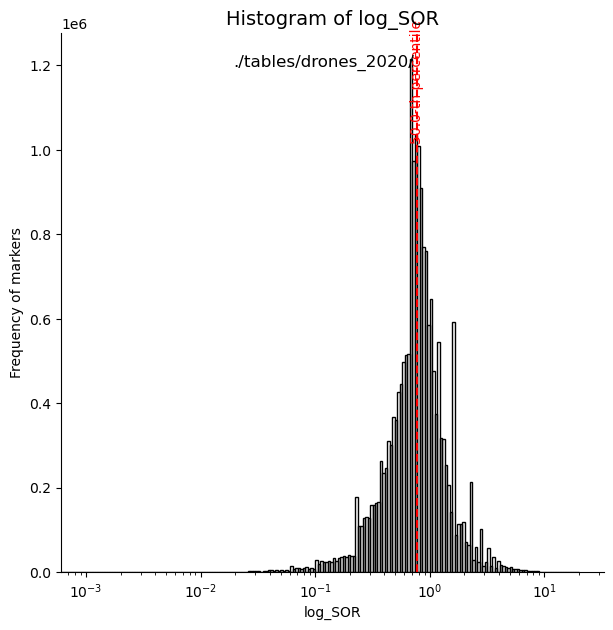

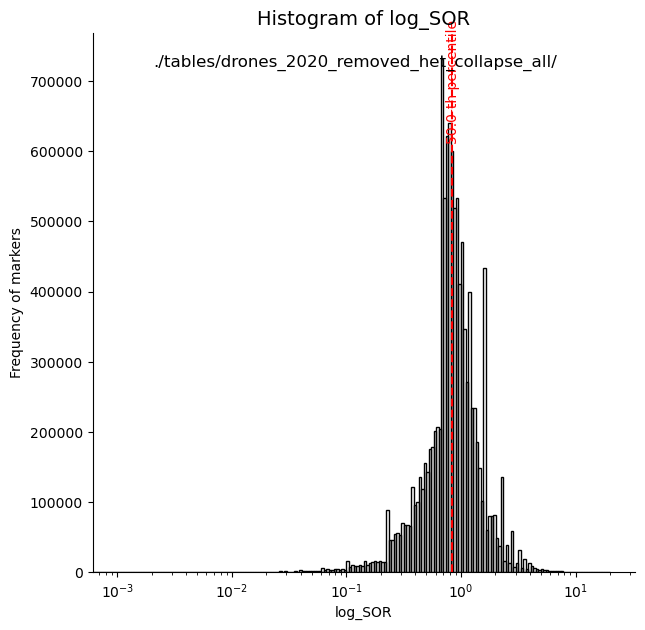

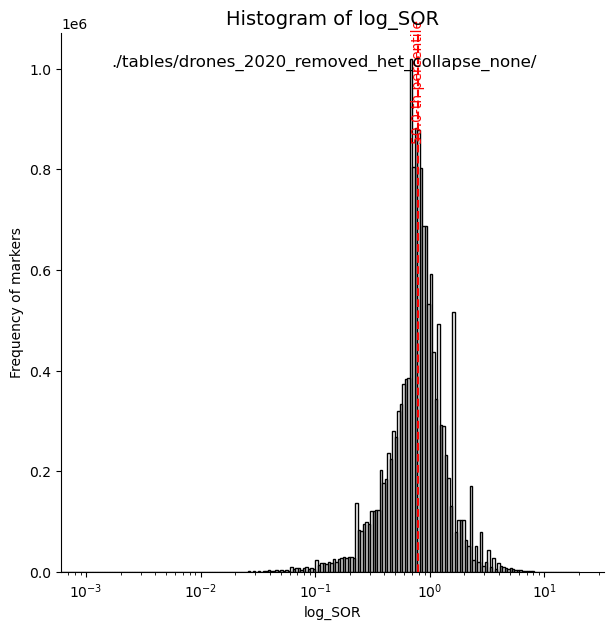

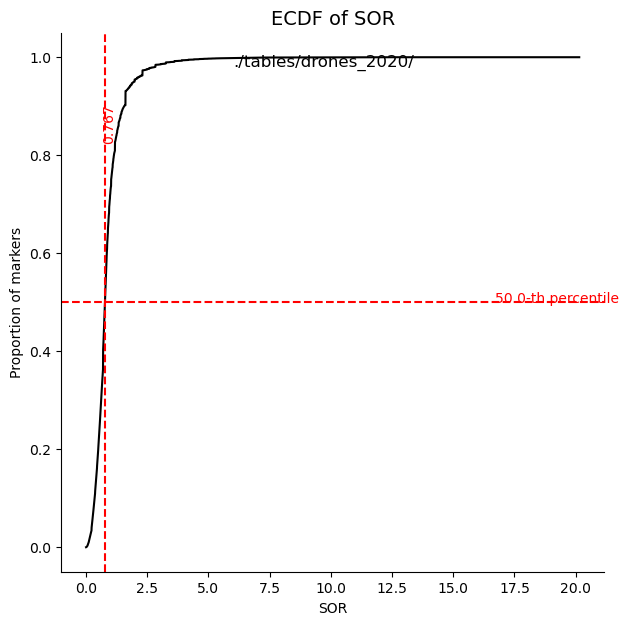

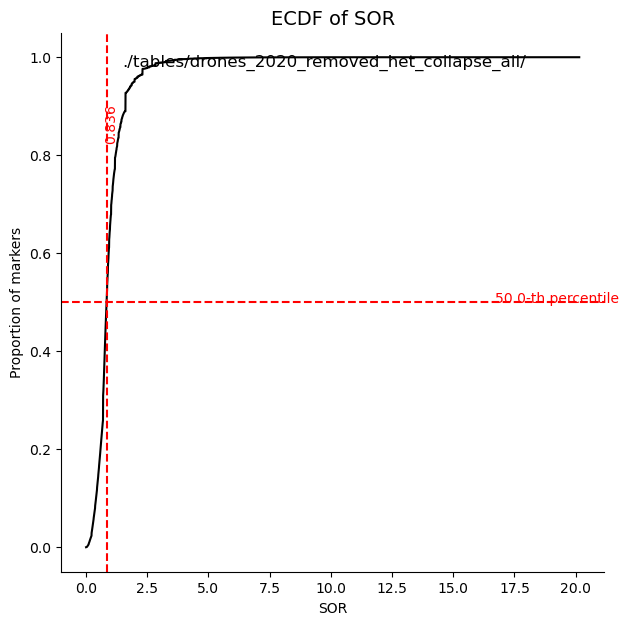

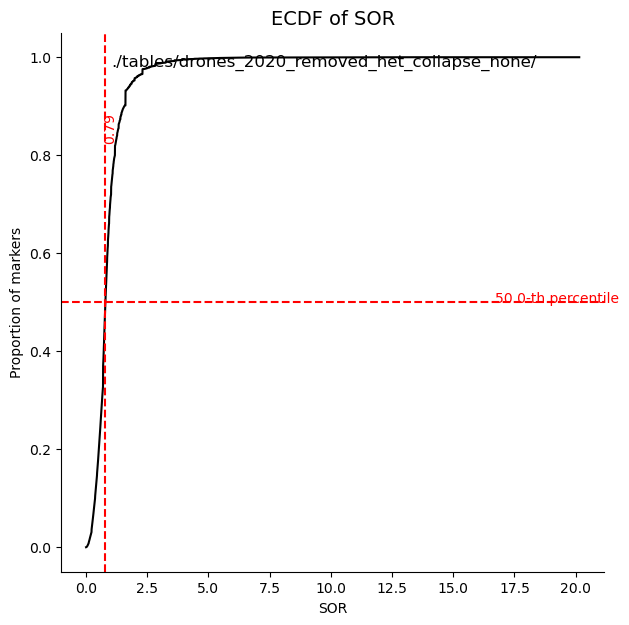

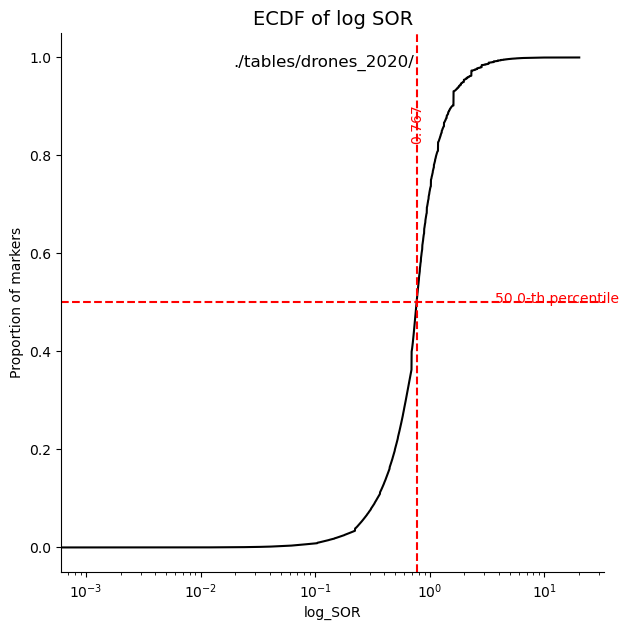

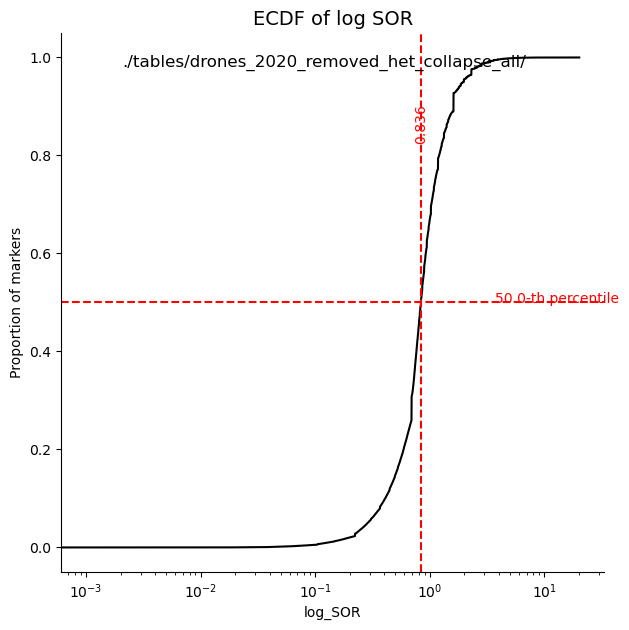

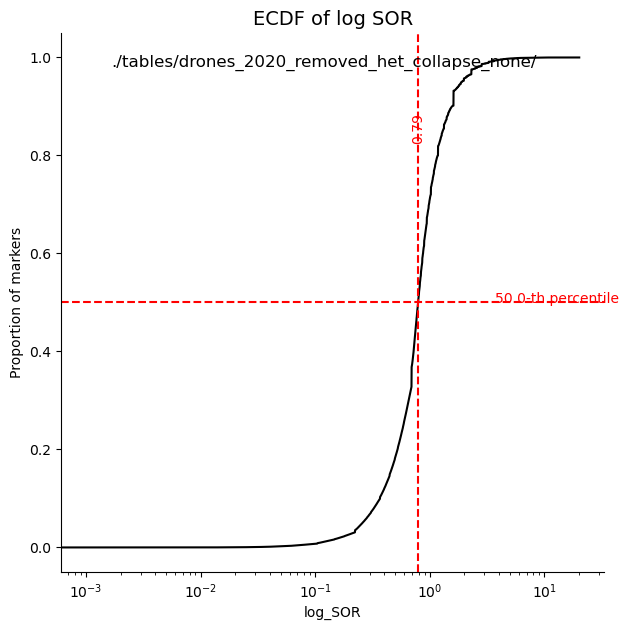

In [8]:
filter_name = "SOR"
filter_value = 0.5  # could have a list of values to iterate along the paths -- use zip for this
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_log_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}", y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_log_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)

## Fisher Strand historgram of FS

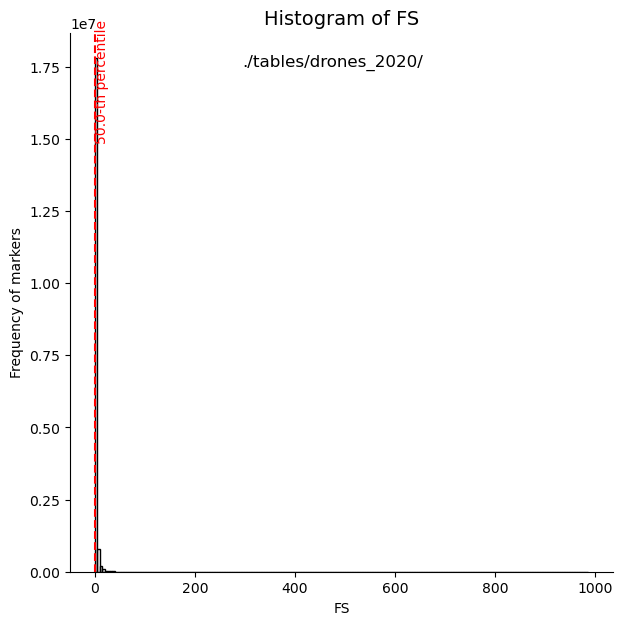

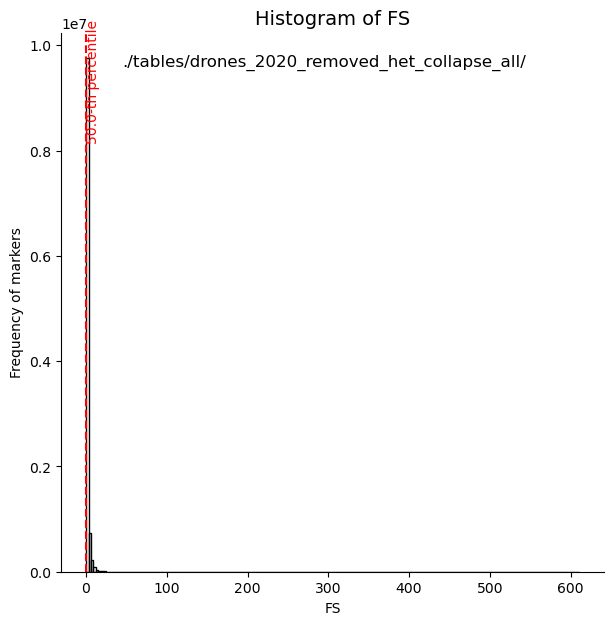

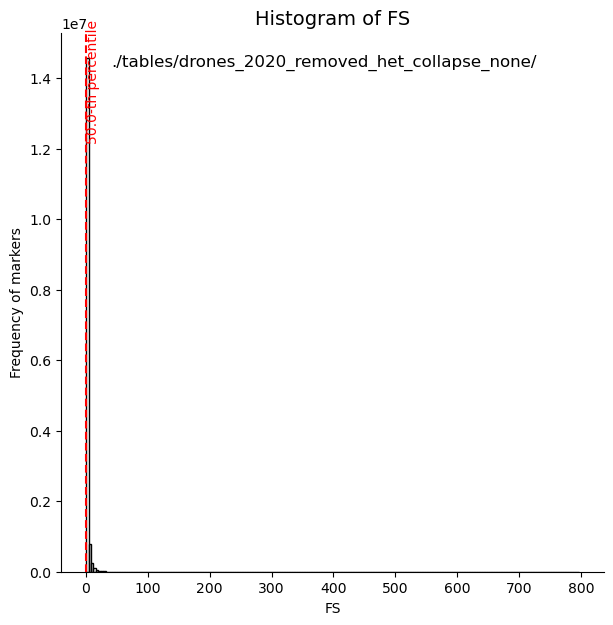

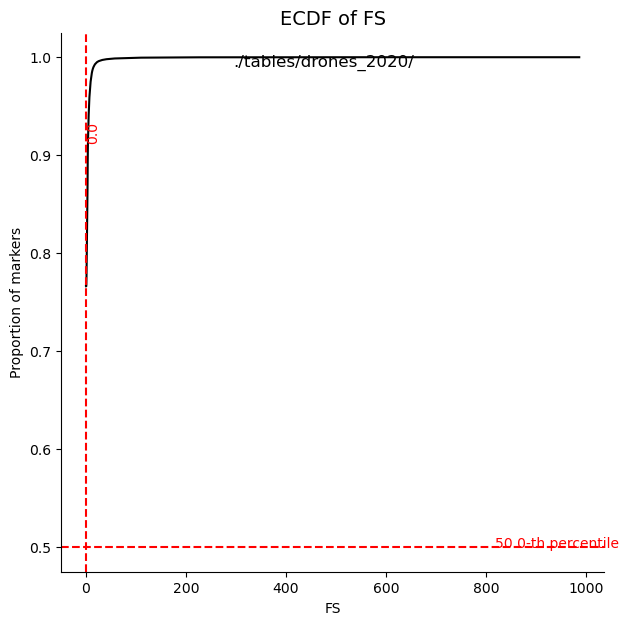

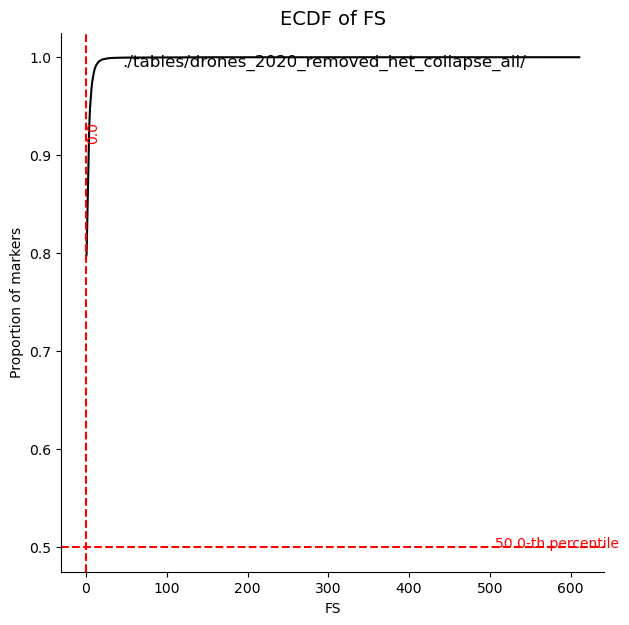

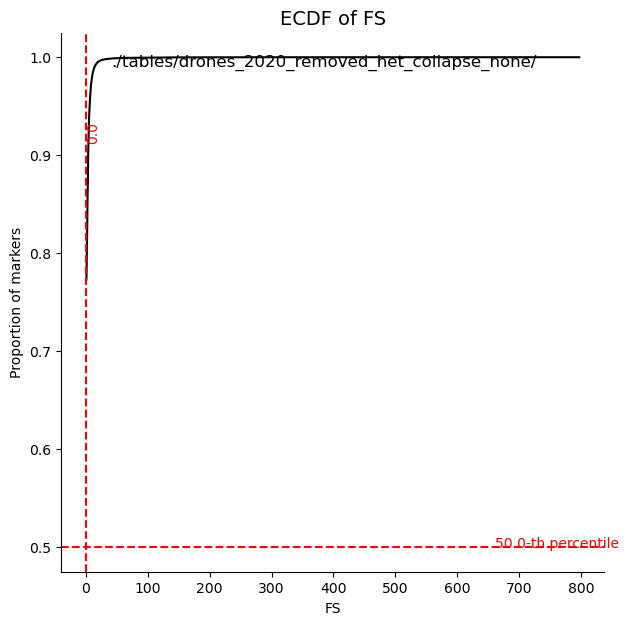

In [21]:
filter_name = "FS"
filter_value = 0.5

for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)

    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}", y=0.85)
    

    

## Mapping quality (MQ)

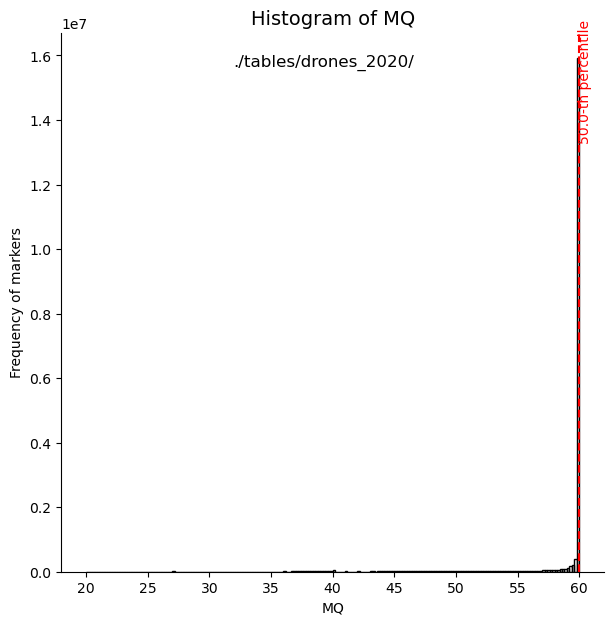

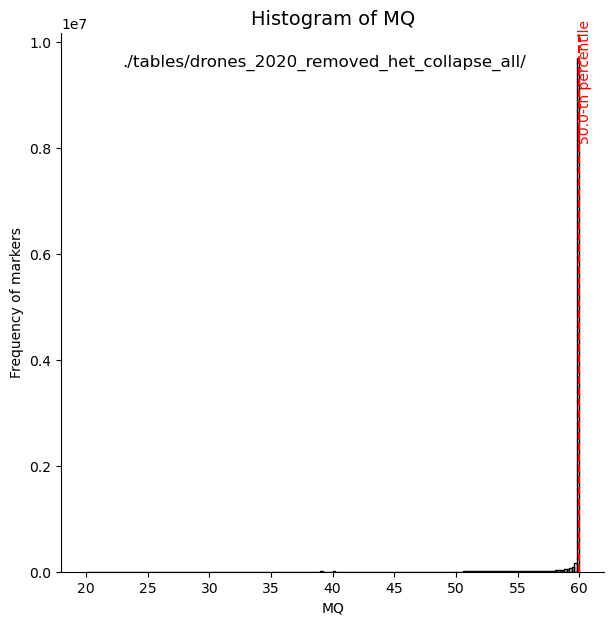

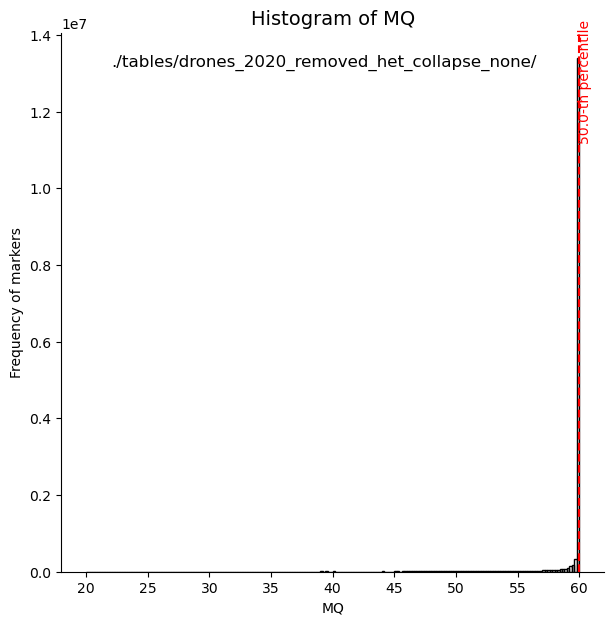

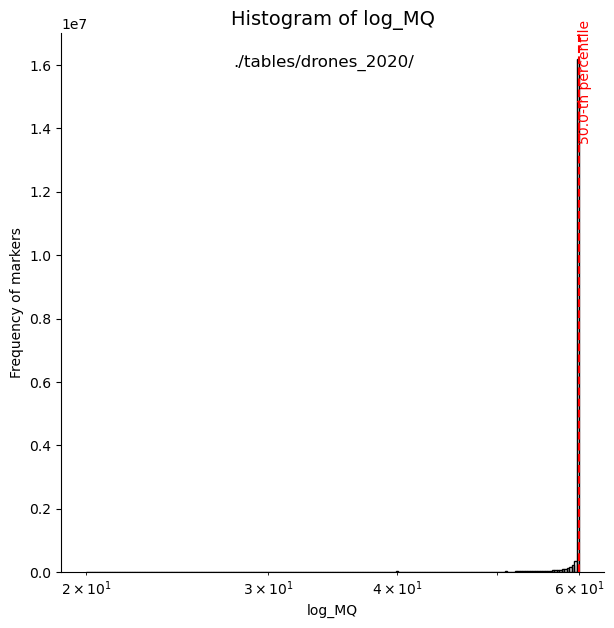

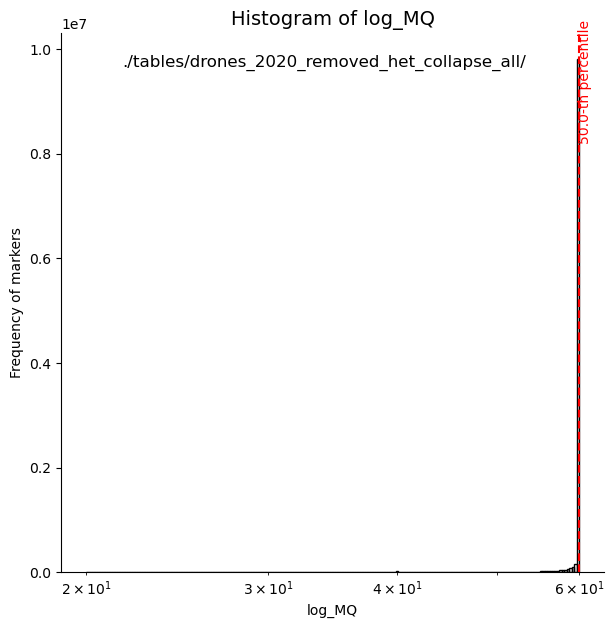

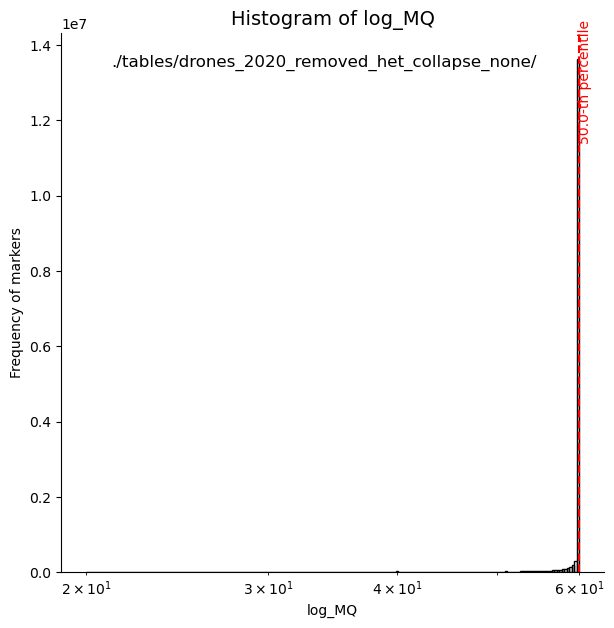

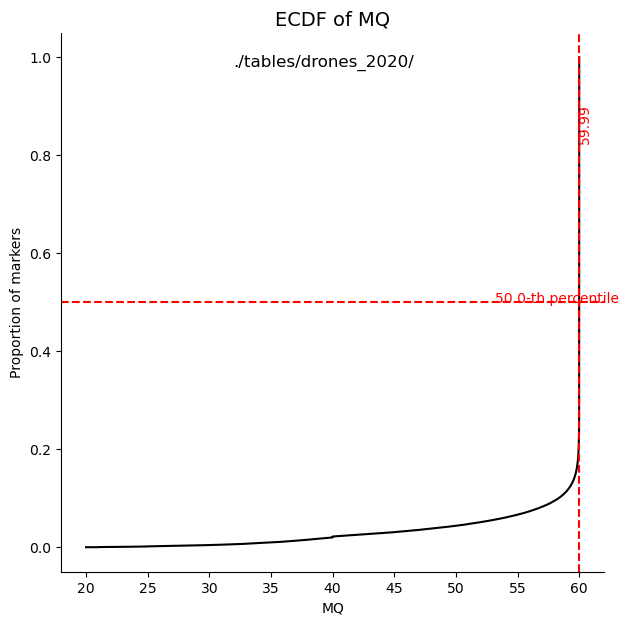

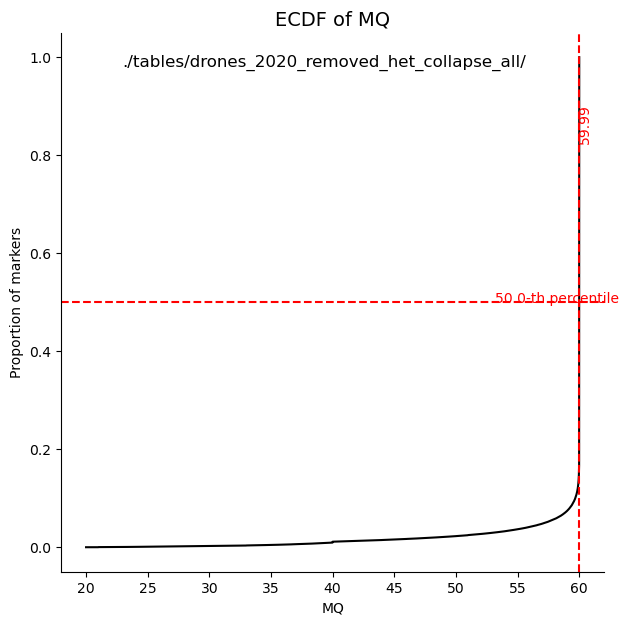

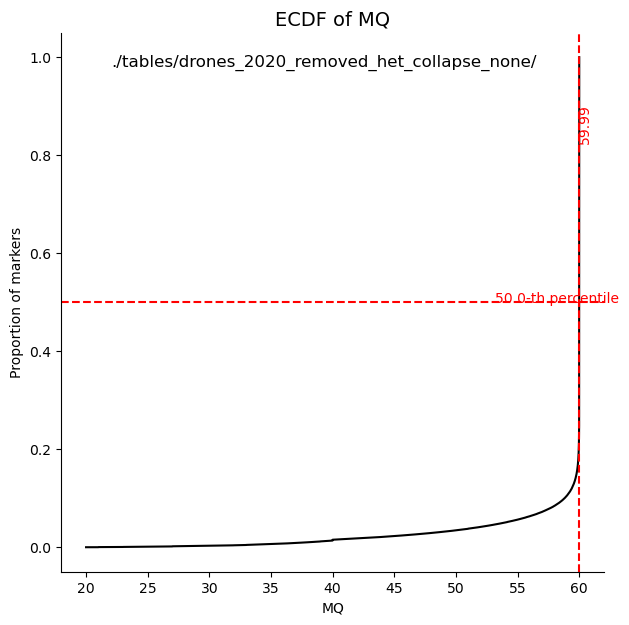

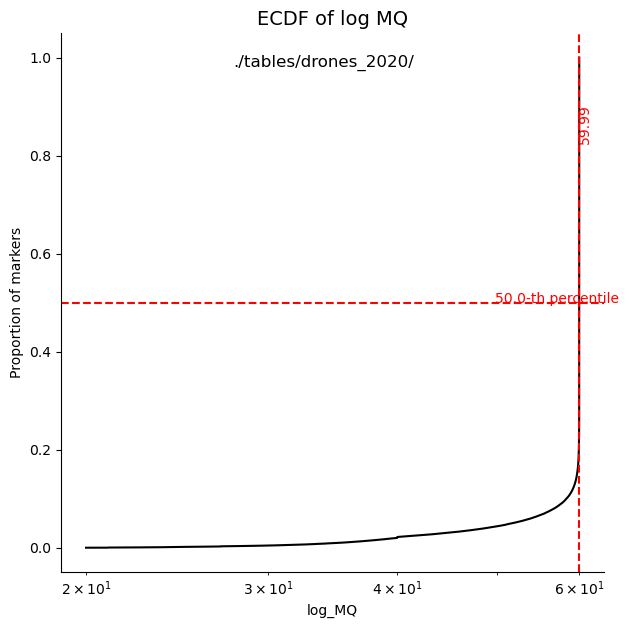

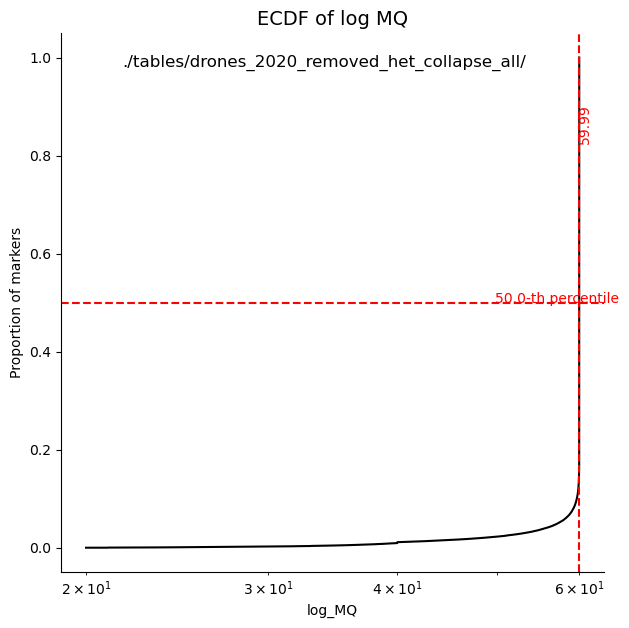

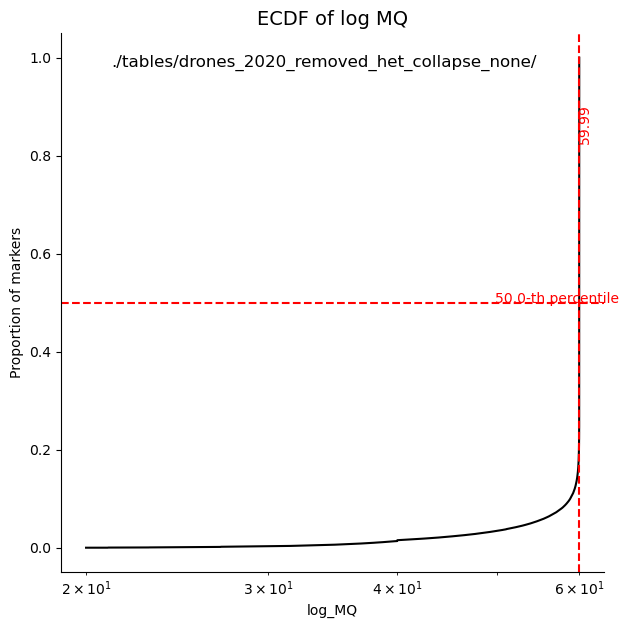

In [53]:
filter_name = "MQ"
filter_value = 0.5  # could have a list of values to iterate along the paths -- use zip for this
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_log_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}", y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_log_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)

## SNP quality (QUAL)

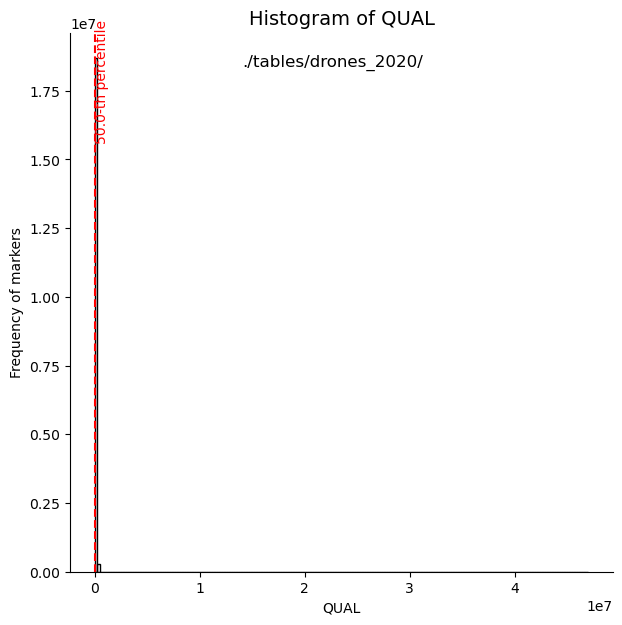

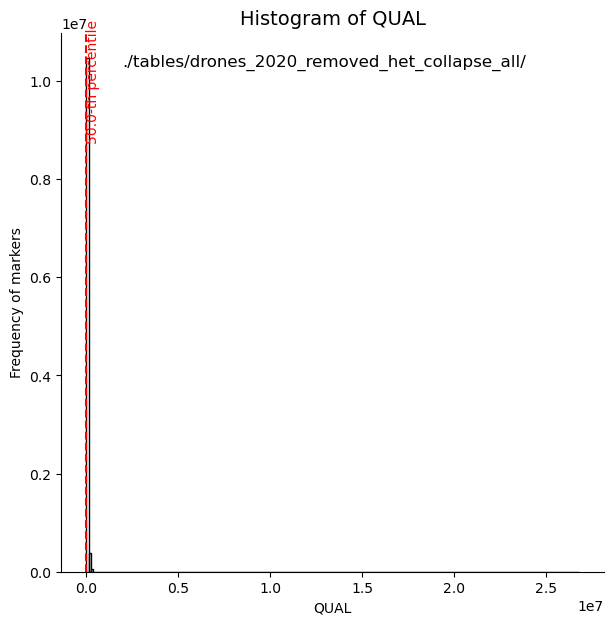

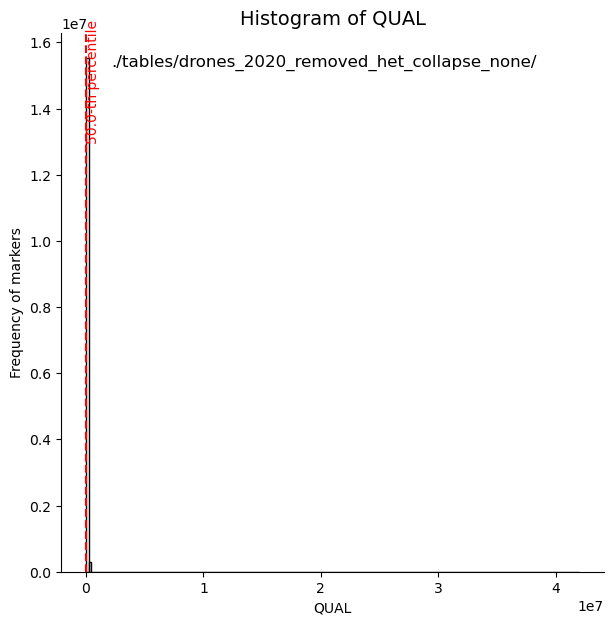

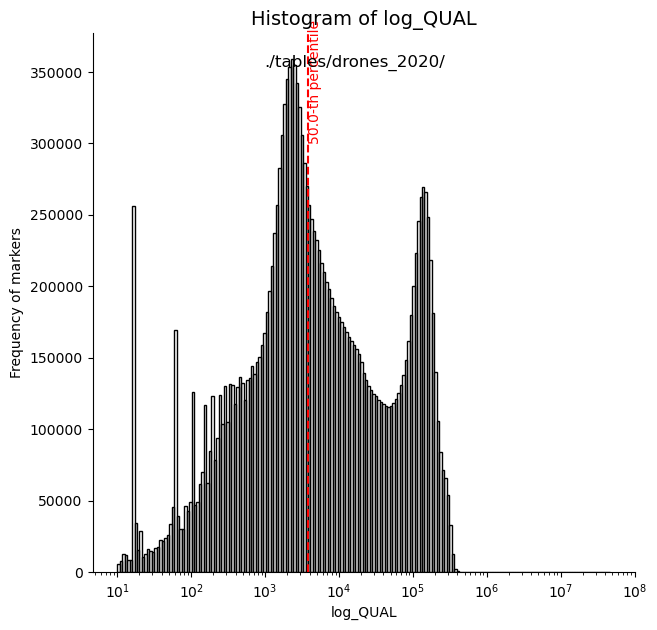

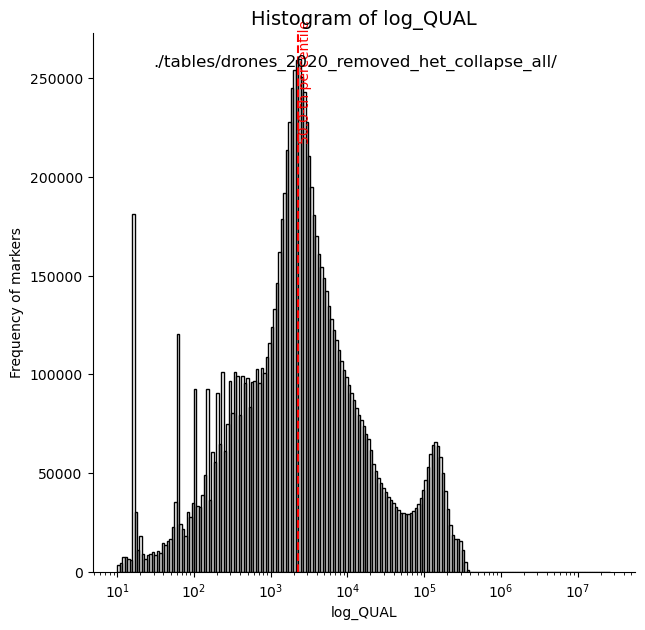

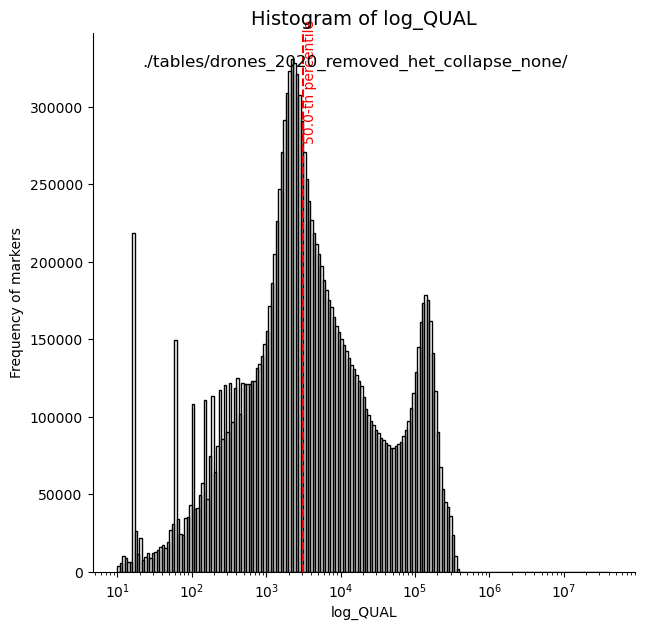

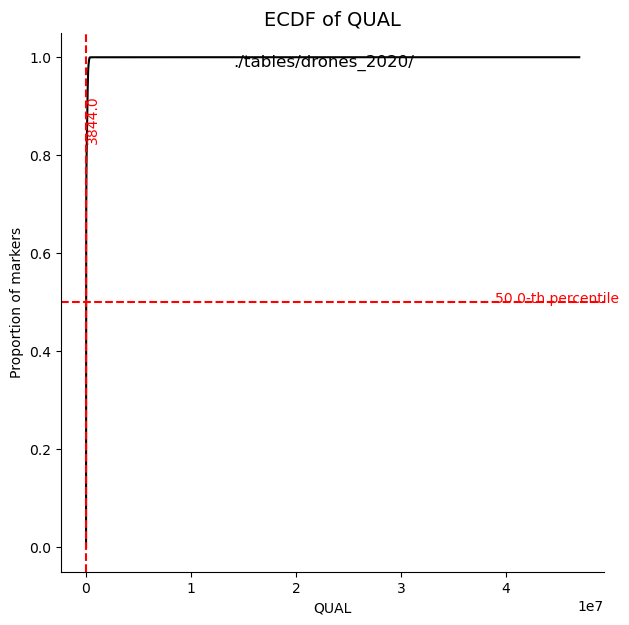

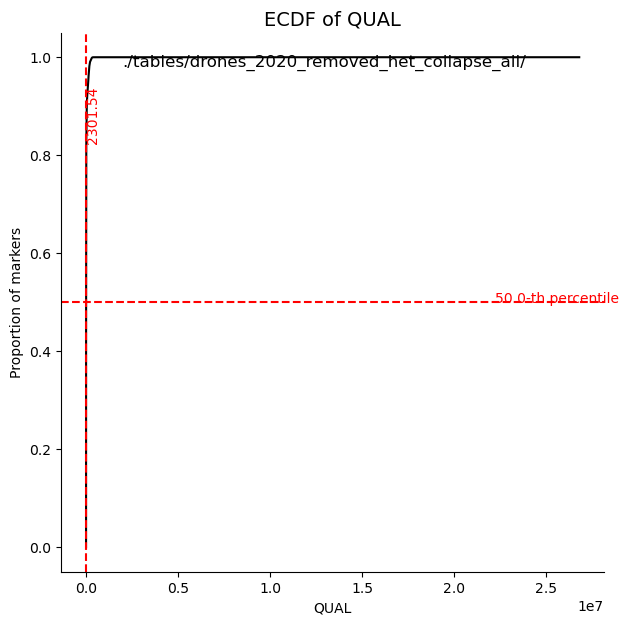

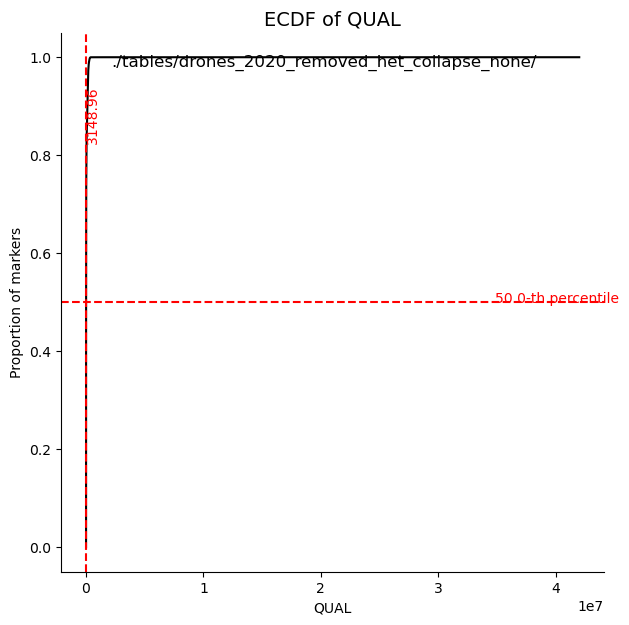

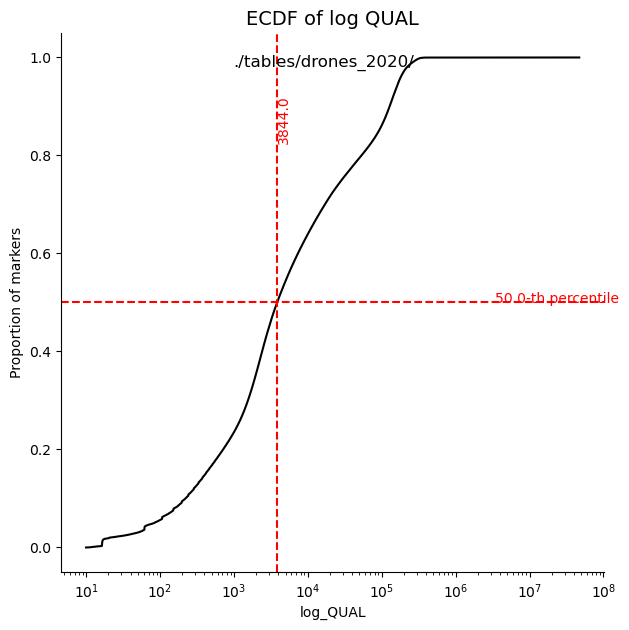

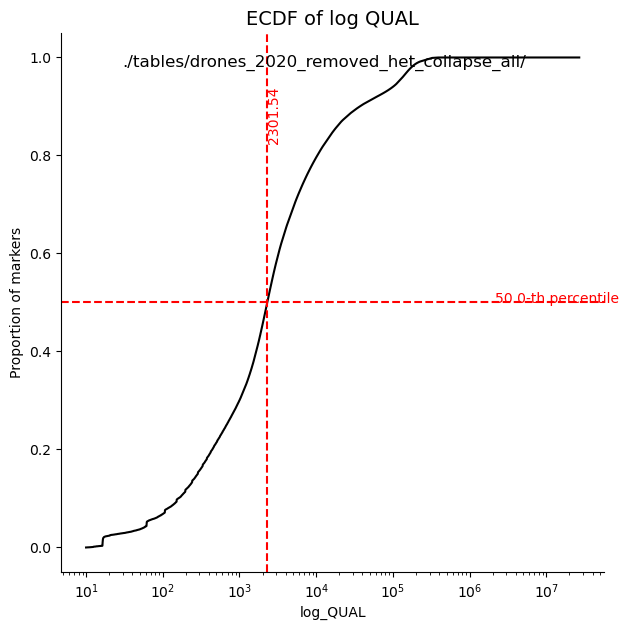

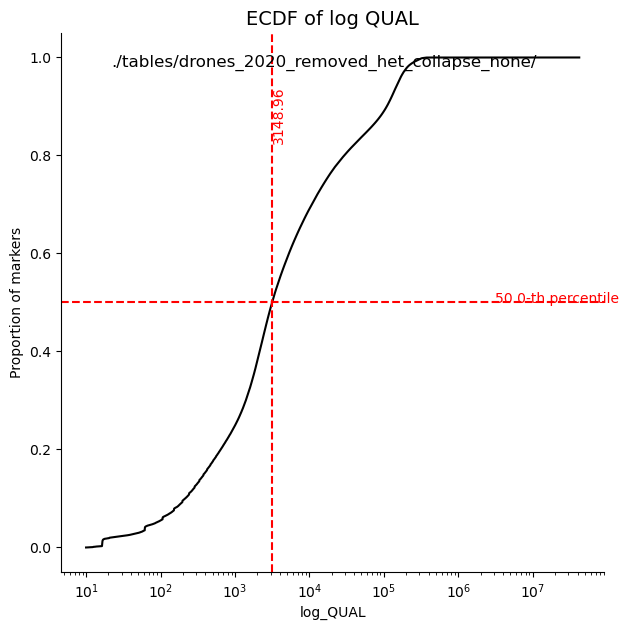

In [52]:
filter_name = "QUAL"
filter_value = 0.5  # could have a list of values to iterate along the paths -- use zip for this
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_log_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")    
    plot_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}", y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_log_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)

## QD

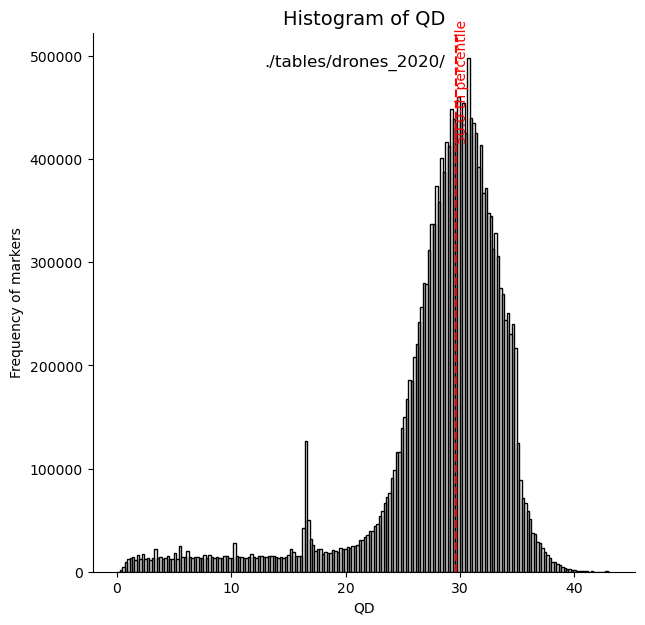

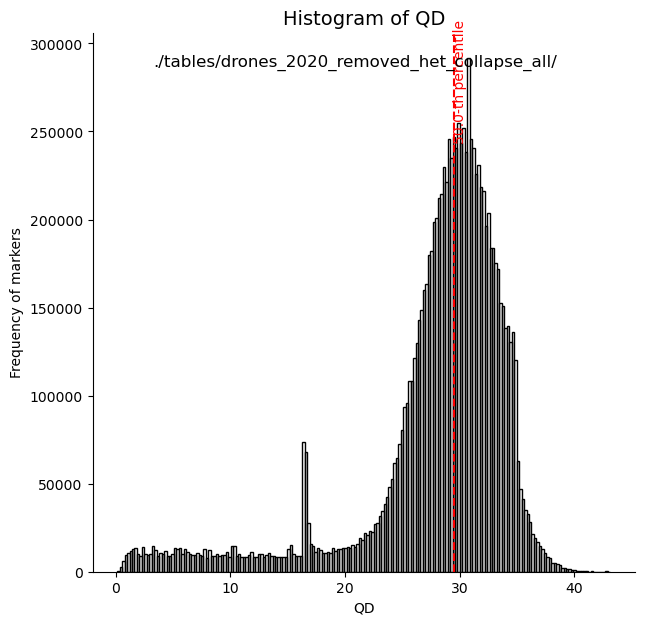

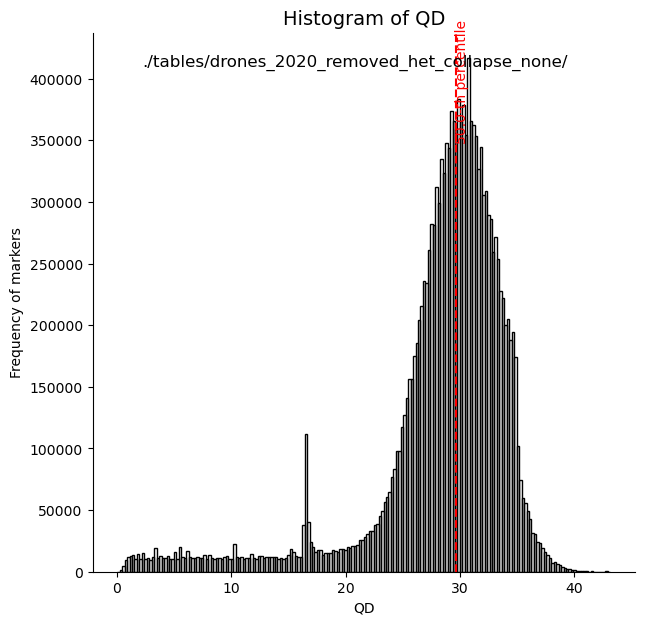

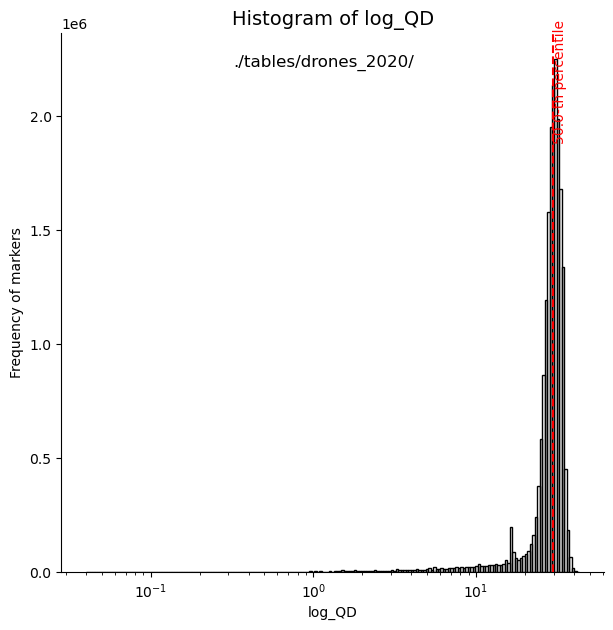

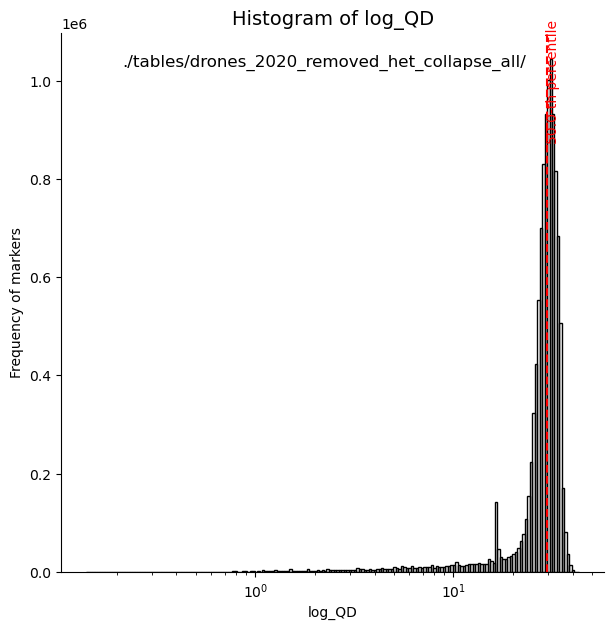

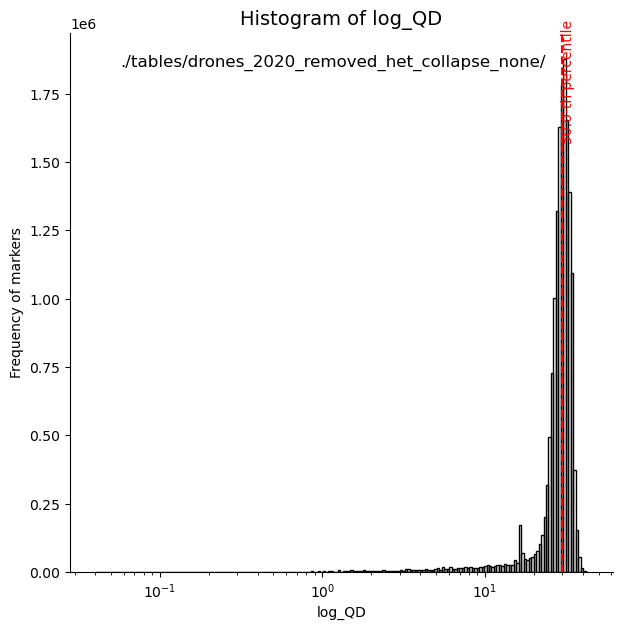

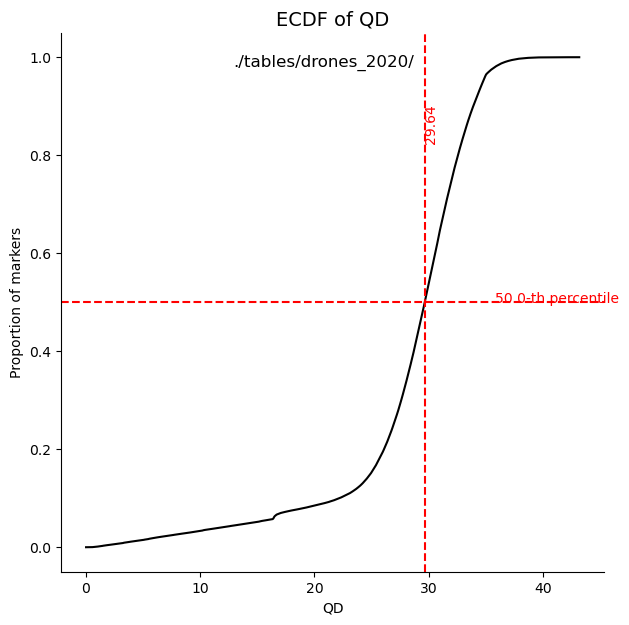

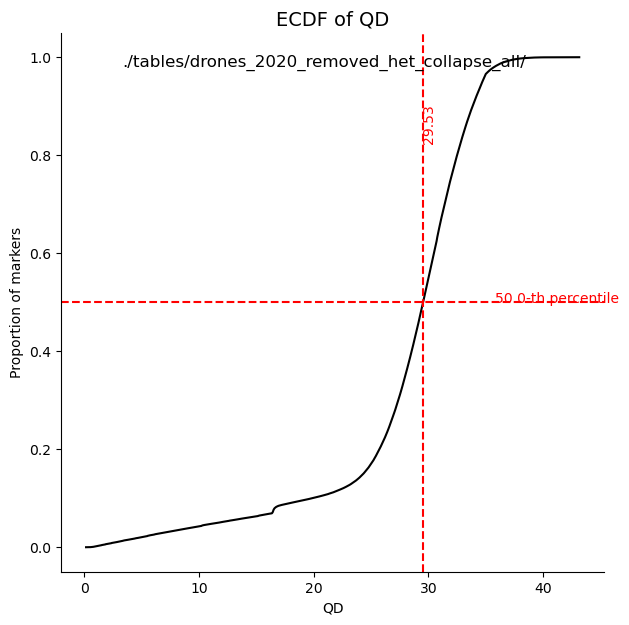

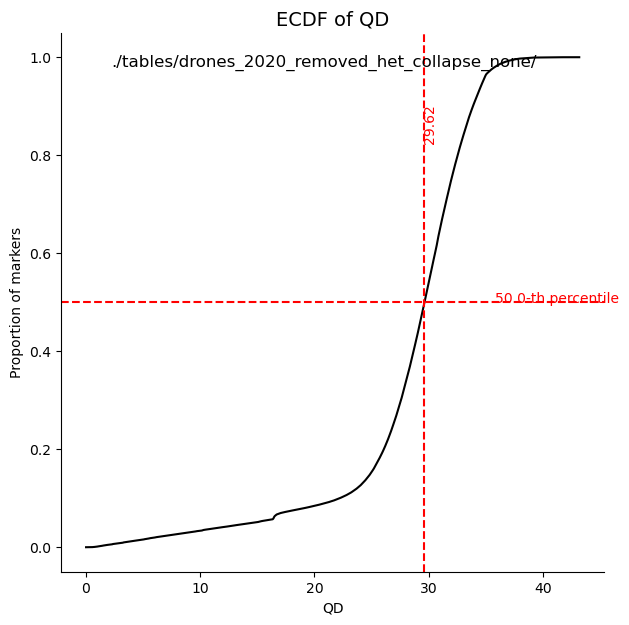

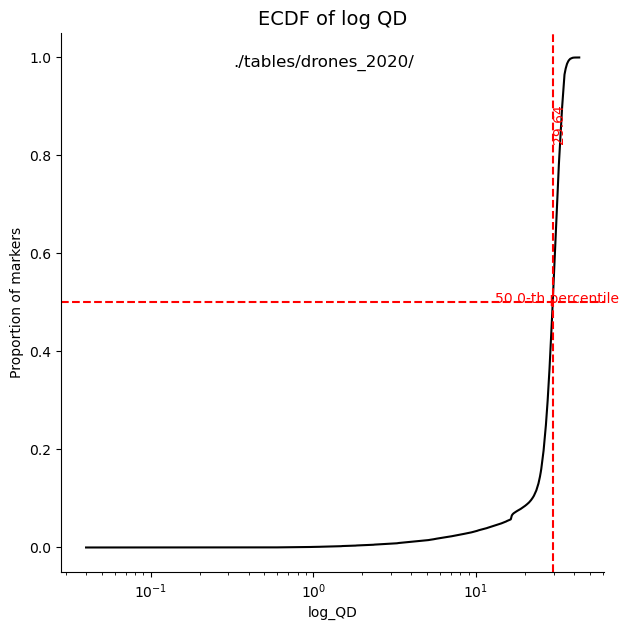

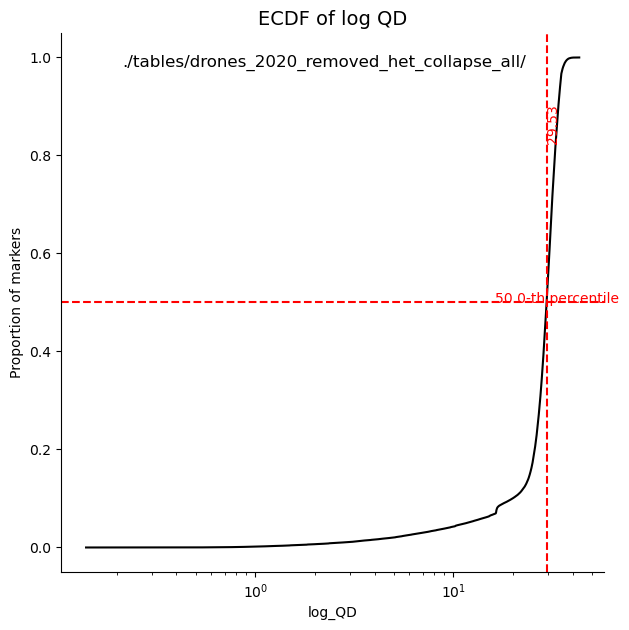

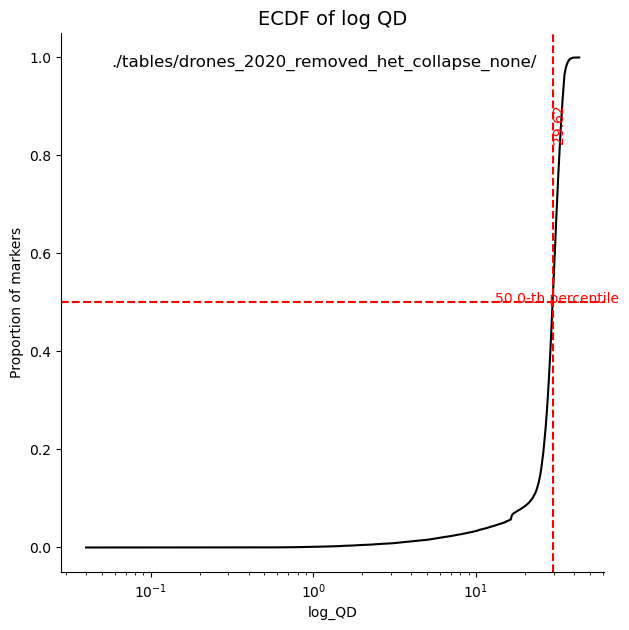

In [12]:
filter_name = "QD"
filter_value = 0.5  # could have a list of values to iterate along the paths -- use zip for this
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_log_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}", y=0.85)
    
for path, info_table in zip(paths, info_tables):
    data = info_table[filter_name].dropna().to_numpy(dtype="float")
    plot_log_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)

## Het

In [23]:
# Here we need to be careful since we need a different data set than for the rest,
# therefore we call get_het_or_miss function
filter_name = "het"

filter_value = 0.5  # could have a list of values to iterate along the paths -- use zip for this
data = get_het_or_miss(paths[0], filter_name)
#for path, info_table in zip(paths, info_tables):
#    df, data = get_het_or_miss(path, filter_name)
#    plot_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
#    plt.suptitle(f"{path}",  y=0.85)
    
#for path, info_table in zip(paths, info_tables):
#    df, data = get_het_or_miss(path, filter_name)
#    plot_log_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
#    plt.suptitle(f"{path}",  y=0.85)
#    
#for path, info_table in zip(paths, info_tables):
#    df, data = get_het_or_miss(path, filter_name)
#    plot_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
#    plt.suptitle(f"{path}", y=0.85)
#    
#for path, info_table in zip(paths, info_tables):
#    df, data = get_het_or_miss(path, filter_name)
#    plot_log_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
#    plt.suptitle(f"{path}",  y=0.85)


KeyboardInterrupt: 

## Miss

In [16]:
filter_name = "miss"
filter_value = 0.5  # could have a list of values to iterate along the paths -- use zip for this
for path, info_table in zip(paths, info_tables):
    df, data = get_het_or_miss(path, filter_name)
    plot_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)
    
for path, info_table in zip(paths, info_tables):
    df, data = get_het_or_miss(path, filter_name)
    plot_log_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)
    
for path, info_table in zip(paths, info_tables):
    df, data = get_het_or_miss(path, filter_name)
    plot_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}", y=0.85)
    
for path, info_table in zip(paths, info_tables):
    plot_log_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)

KeyboardInterrupt: 

## GQ

In [24]:
gt_file_list = [file for file in glob.glob(f"{path}*.gq")]
print(gt_file_list)
print(path
     )

['./tables/drones_2020_removed_het_collapse_none/gq_drones-2020_removed_het_collapse_none_fp.gq', './tables/drones_2020_removed_het_collapse_none/gq_drones-2020_removed_het_collapse_none_eg.gq', './tables/drones_2020_removed_het_collapse_none/gq_drones-2020_removed_het_collapse_none_cu.gq', './tables/drones_2020_removed_het_collapse_none/gq_drones-2020_removed_het_collapse_none_ae.gq', './tables/drones_2020_removed_het_collapse_none/gq_drones-2020_removed_het_collapse_none_cz.gq', './tables/drones_2020_removed_het_collapse_none/gq_drones-2020_removed_het_collapse_none_az.gq', './tables/drones_2020_removed_het_collapse_none/gq_drones-2020_removed_het_collapse_none_aw.gq', './tables/drones_2020_removed_het_collapse_none/gq_drones-2020_removed_het_collapse_none_ah.gq', './tables/drones_2020_removed_het_collapse_none/gq_drones-2020_removed_het_collapse_none_df.gq', './tables/drones_2020_removed_het_collapse_none/gq_drones-2020_removed_het_collapse_none_ad.gq', './tables/drones_2020_removed

In [26]:
filter_name = "GQ"
gq_cutoff = 10  # the GQ score we are using as a threshold

for path in paths[1:]:
    data = get_gq(path)
    filter_value = 0.1  # the proportion of samples with GQ less than gq_cutoff per snp
    filter_value = 0.5

    plot_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    #plot_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    #plot_log_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    #plot_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    #plot_log_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [56]:
# Show the counts of SNPs which have the proporiton of samples with GQ less than filter value/threshold. We decide the
# filter threshold and the prportion of samples that have GQ below this threshold
#TODO: Must check if the way proportion is calculated is correct, do we divide by all samples number or by only the
# number of samples which have the genotype called? For now it remains as in the example
filter_name = "GQ_proportion"
gq_cutoff = 10  # the GQ score we are using as a threshold

filter_value = 0.5  # could have a list of values to iterate along the paths -- use zip for this
for path, info_table in zip(paths, info_tables):
    df, data_gq_prop = get_gq_proportion(path, gq_cutoff)
    plot_histogram(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}",  y=0.85)
    
    
for path, info_table in zip(paths, info_tables):
    df, data_gq_prop = get_gq_proportion(path, gq_cutoff)
    plot_ecdf(filter_name=filter_name, filter_value=filter_value, data=data, quant=True)
    plt.suptitle(f"{path}", y=0.85)



KeyError: 'GQ_proportion'

In [12]:
# magic to find out the port/connection info,  needed for manually connecting a gt console to jupyter notebook
%connect_info

# another option is to just use the automagic function
#%qtconsole

{
  "shell_port": 58135,
  "iopub_port": 47820,
  "stdin_port": 52261,
  "control_port": 54420,
  "hb_port": 42556,
  "ip": "127.0.0.1",
  "key": "732e58c8-b55b8a15b7f6c9b084533e71",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-35234c86-a696-4c7e-8643-52817def1276.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
